In [1]:
from pathlib import Path

METRICS_DIR = Path("eval/metrics")
evaluations = list(METRICS_DIR.glob("*.json"))


In [2]:
import json

model_evaluations = {}

for evaluation_json in evaluations:
    with open(evaluation_json, "r", encoding="utf-8") as f:
        model_evaluations[evaluation_json.stem] = json.load(f)

# model_evaluations: {model_name: {query: result}}

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = {}
for model, queries in model_evaluations.items():
    df = pd.DataFrame(queries).T
    data[model] = df.mean()

df_summary = pd.DataFrame(data).T


In [25]:
df_summary.sort_values("map", ascending=True, inplace=True)

In [27]:
df_summary.index

Index(['sentence-transformers-all-MiniLM-L6-v2', 'google-embeddinggemma-300m',
       'beademiguelperez-sentence-transformers-multilingual-e5-small',
       'intfloat-multilingual-e5-large', 'xmanii-maux-gte-persian-v3'],
      dtype='object')

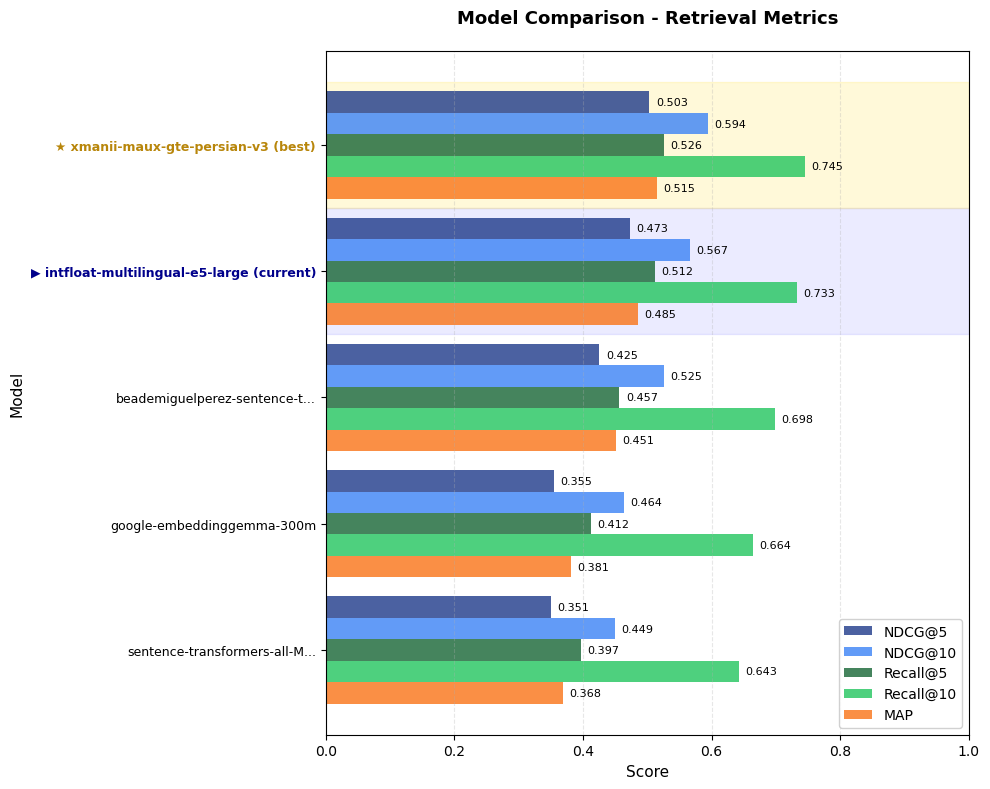

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with better size for horizontal bars
fig, ax = plt.subplots(figsize=(10, 8))

# Prepare data
metrics = ["ndcg_cut_5", "ndcg_cut_10", "recall_5", "recall_10", "map"]
metric_labels = ["NDCG@5", "NDCG@10", "Recall@5", "Recall@10", "MAP"]
models = df_summary.index.tolist()

# Define special models
current_model = "intfloat-multilingual-e5-large"
best_model = "xmanii-maux-gte-persian-v3"

# Define colors - shades of blue for NDCG, shades of green for Recall, orange for MAP
colors = [
    "#1e3a8a",
    "#3b82f6",
    "#166534",
    "#22c55e",
    "#f97316",
]  # dark blue, light blue, dark green, light green, orange


# Truncate model names and add tooltips
def truncate_name(name, max_length=30):
    if len(name) <= max_length:
        return name
    return name[: max_length - 3] + "..."


truncated_names = [truncate_name(model) for model in models]

# Add markers to special models
for i, model in enumerate(models):
    if model == current_model:
        truncated_names[i] = "▶ " + truncated_names[i] + " (current)"
    elif model == best_model:
        truncated_names[i] = "★ " + truncated_names[i] + " (best)"

# Set up bar positions
x = np.arange(len(models))
width = 0.17

# Create bars for each metric with specified colors
plots = [
    ax.barh(
        x + (len(metrics) // 2 - i) * width,
        df_summary[metrics[i]],
        width,
        label=metric_labels[i],
        alpha=0.8,
        color=colors[i],
    )
    for i in range(len(metrics))
]

# Highlight special model rows with background color
for i, model in enumerate(models):
    if model == current_model:
        ax.axhspan(i - 0.5, i + 0.5, color="blue", alpha=0.08, zorder=0)
    elif model == best_model:
        ax.axhspan(i - 0.5, i + 0.5, color="gold", alpha=0.15, zorder=0)

# Customize the plot
ax.set_xlabel("Score", fontsize=11)
ax.set_ylabel("Model", fontsize=11)
ax.set_title(
    "Model Comparison - Retrieval Metrics", fontsize=13, fontweight="bold", pad=20
)
ax.set_yticks(x)
ax.set_yticklabels(truncated_names, fontsize=9)

# Make special model labels bold and colored
for i, (tick, model) in enumerate(zip(ax.get_yticklabels(), models)):
    if model == current_model:
        tick.set_weight("bold")
        tick.set_color("darkblue")
    elif model == best_model:
        tick.set_weight("bold")
        tick.set_color("darkgoldenrod")

ax.set_xlim(0, 1)
ax.legend(loc="lower right", framealpha=0.9)
ax.grid(axis="x", alpha=0.3, linestyle="--")

# Add value labels on bars
for bars in plots:
    for bar in bars:
        width_val = bar.get_width()
        ax.text(
            width_val + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{width_val:.3f}",
            ha="left",
            va="center",
            fontsize=8,
        )

plt.tight_layout()
plt.show()

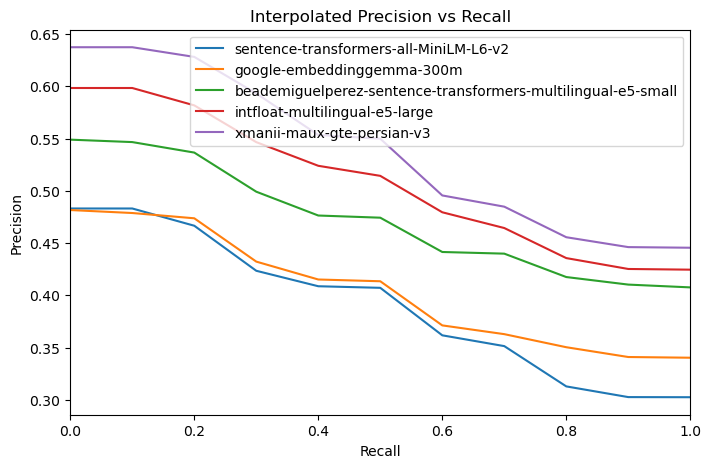

In [44]:
import re

iprec_cols = [c for c in df_summary.columns if re.match(r"iprec_at_recall_", c)]
df_iprec = df_summary[iprec_cols].T
df_iprec.index = [float(c.split("_")[-1]) for c in iprec_cols]
df_iprec.plot(figsize=(8, 5), title="Interpolated Precision vs Recall")
plt.xlim(0, 1)
# plt.ylim(top=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


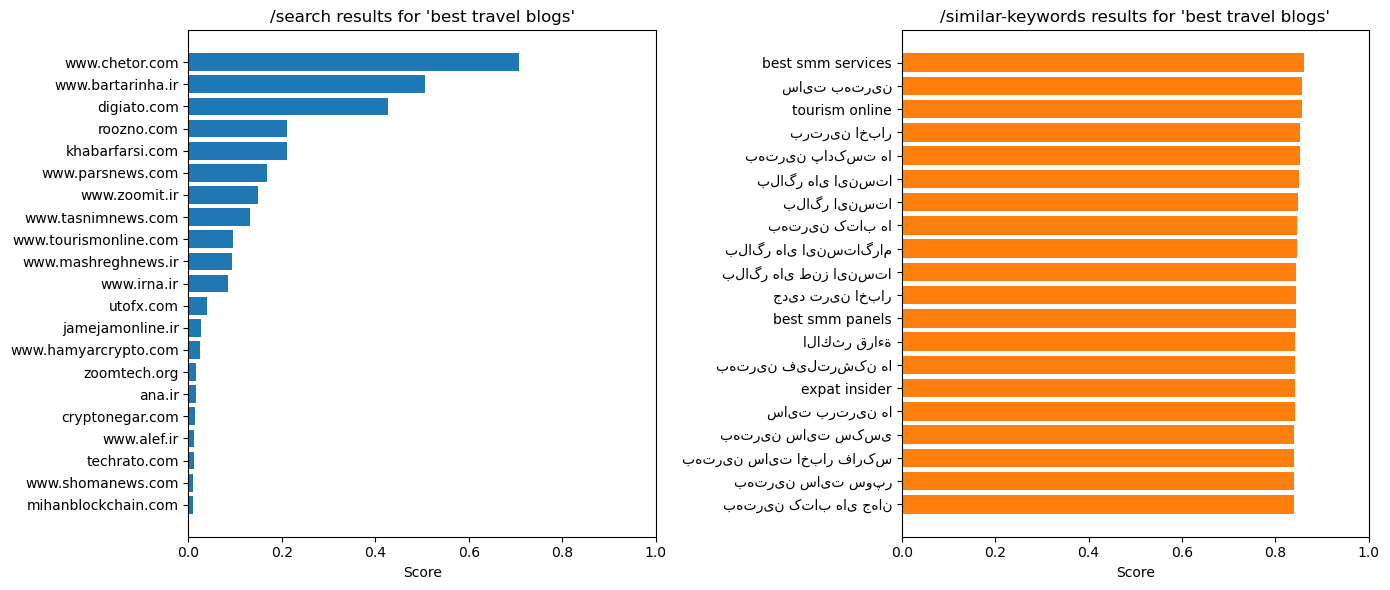

In [40]:
import requests
import matplotlib.pyplot as plt
import pandas as pd

# --- CONFIG ---
BASE_URL = "http://185.8.172.121:8000"  # change to your server


def query_api(endpoint: str, query: str, top_k: int | None = None) -> pd.DataFrame:
    """
    Sends a GET request to a given endpoint and returns a DataFrame of results.
    The endpoint must return either 'score' or 'similarity' as the numeric field.
    """
    url = f"{BASE_URL}/{endpoint}"
    params = {"query": query, "top_k": top_k}
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    df = pd.DataFrame(data)

    # Normalize column names for visualization
    if "similarity" in df.columns:
        df = df.rename(columns={"similarity": "score", "keyword": "website"})

    df["endpoint"] = endpoint
    return df


def visualize_side_by_side(
    df_search: pd.DataFrame, df_similar: pd.DataFrame, query: str
):
    """Displays two bar charts side-by-side for /search and /similar-keywords."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, (df, title) in zip(
        axes,
        [(df_search, "/search results"), (df_similar, "/similar-keywords results")],
    ):
        df = df.sort_values("score", ascending=True)
        ax.barh(
            df["website"],
            df["score"],
            color="#1f77b4" if "search" in title else "#ff7f0e",
        )
        ax.set_title(f"{title} for '{query}'")
        ax.set_xlabel("Score")
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


# --- Example usage ---
query = "best travel blogs"
top_k = 20

df_search = query_api("search", query, top_k)
df_similar = query_api("similar-keywords", query, top_k)

visualize_side_by_side(df_search, df_similar, query)
